In [1]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [ ]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())

In [2]:
bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

i = 3 # rider
f1 = bicycle_record_files[i]
f2 = lidar_record_files[i]

with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

data_dir = '../../data/comfort/'
bicycle_rec = load_file(
    os.path.join(data_dir, f1),
    bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    os.path.join(data_dir, f2))

r = Record(lidar_rec, bicycle_rec)
r.sync()

-9.2400000000000091

In [38]:
r._calculate_trials2()

marking cluster 4 as stationary
marking cluster 6 as stationary
marking cluster 7 as stationary
marking cluster 8 as stationary
marking cluster 9 as stationary
marking cluster 12 as stationary
marking cluster 13 as stationary
marking cluster 25 as stationary
marking cluster 116 as stationary
marking cluster 3 as stationary
marking cluster 4 as stationary
marking cluster 5 as stationary
marking cluster 6 as stationary
marking cluster 7 as stationary
marking cluster 8 as stationary
marking cluster 40 as stationary
marking cluster 67 as stationary
marking cluster 9 as stationary
marking cluster 10 as stationary
marking cluster 11 as stationary
marking cluster 12 as stationary
marking cluster 13 as stationary
marking cluster 14 as stationary
marking cluster 21 as stationary
marking cluster 126 as stationary
marking cluster 2 as stationary
marking cluster 6 as stationary
marking cluster 7 as stationary
marking cluster 8 as stationary
marking cluster 12 as stationary
marking cluster 13 as st

<IPython.core.display.Javascript object>


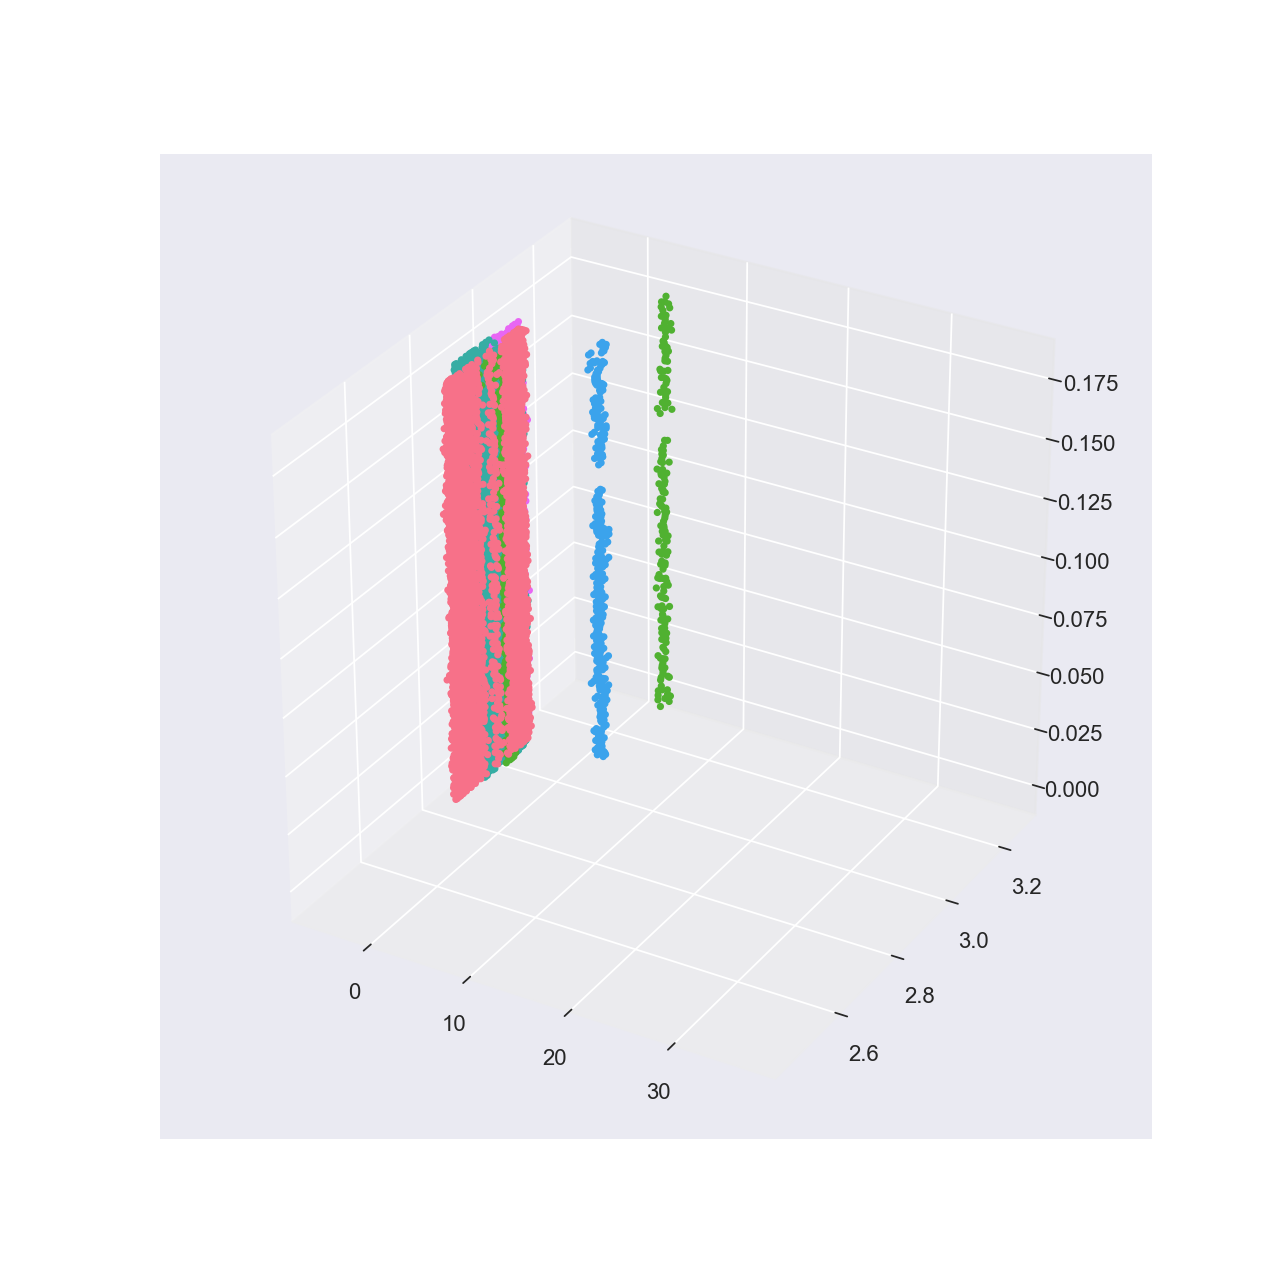

<IPython.core.display.Javascript object>


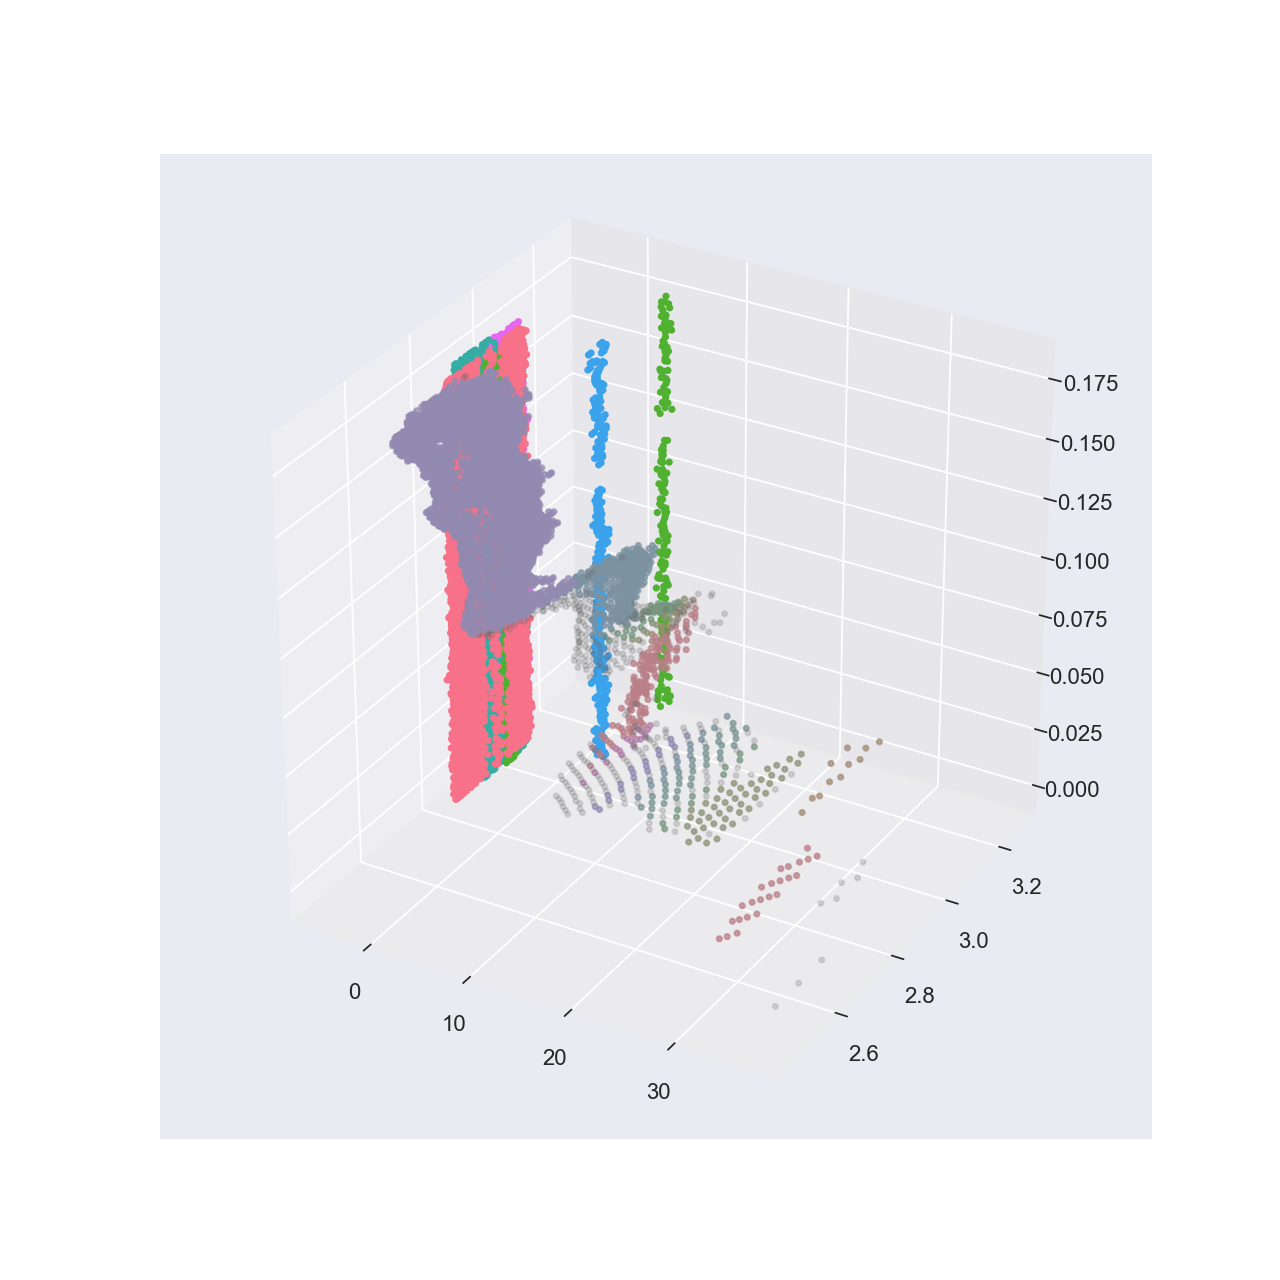

<IPython.core.display.Javascript object>


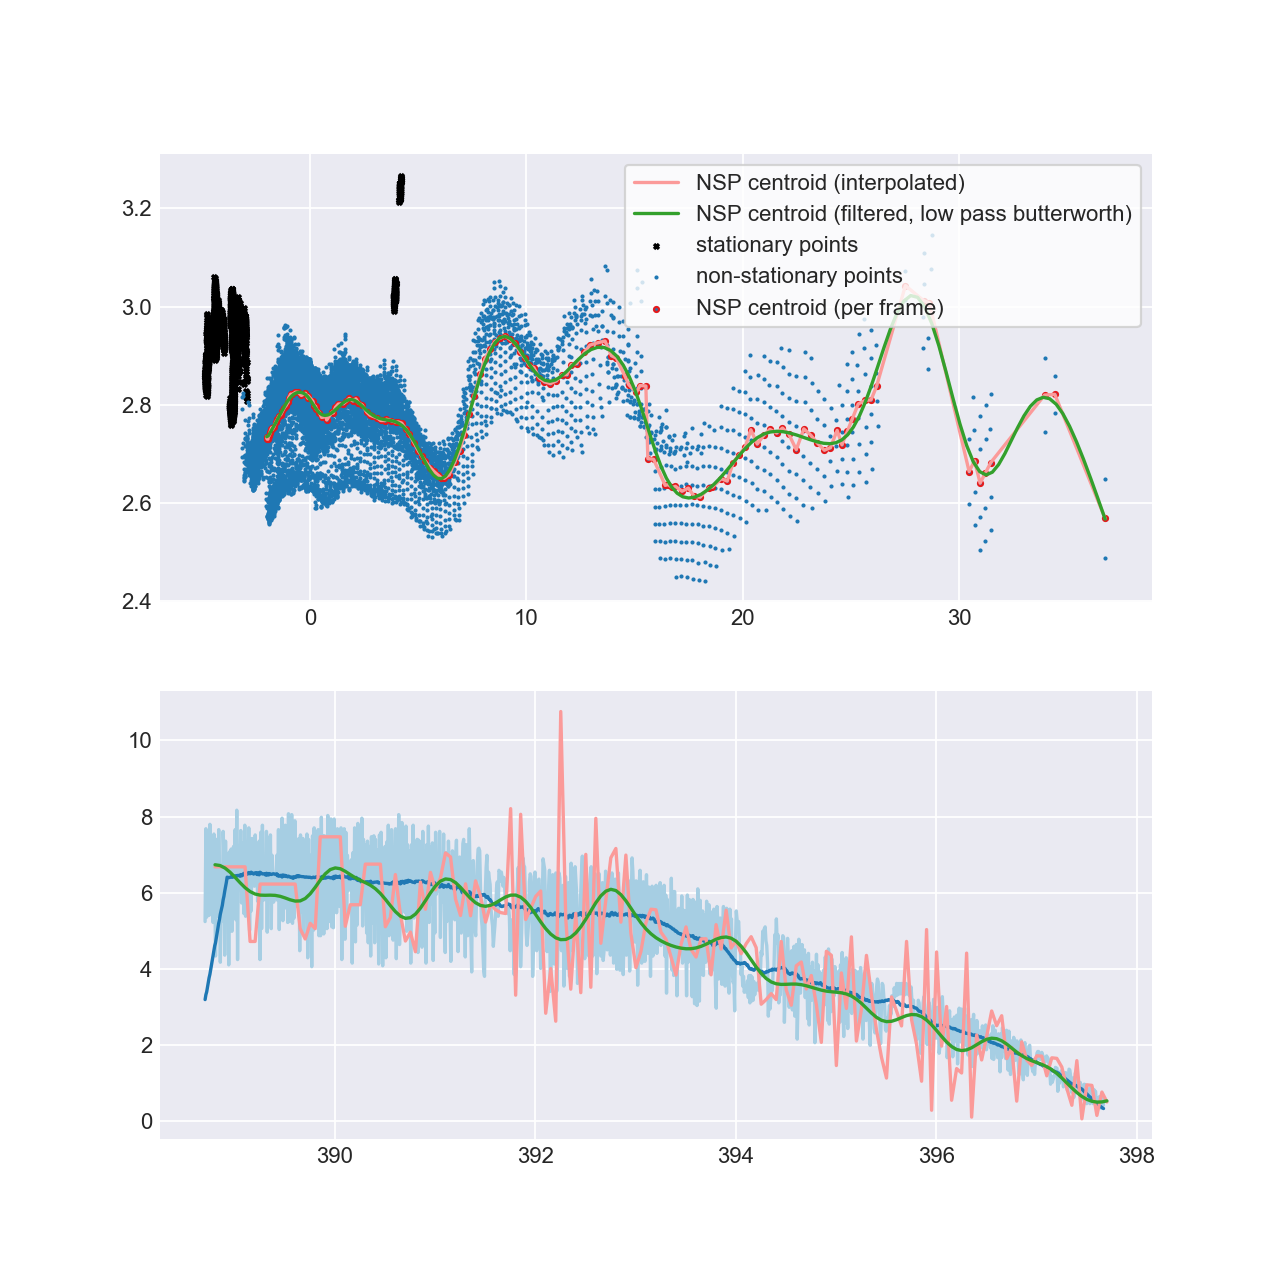

In [147]:
import itertools

plt.close('all')
r.trials[3].event._identify_stationary()

stationary_colors = np.roll(sns.husl_palette(6), -1, axis=0)[1:]
colors = sns.husl_palette(8, l=0.6, s=0.3)
s = itertools.cycle(stationary_colors)
c = itertools.cycle(colors)

def g(stationary):
    def f(cluster):
        kw = {}
        if cluster.label == -1:
            kw['color'] = 'dimgray'
            kw['alpha'] = 0.2 if stationary else 0
        else:
            if cluster.stationary:
                kw['color'] = next(s)
                kw['alpha'] = 1
            else:
                kw['color'] = next(c)
                kw['alpha'] = 0.7 if stationary else 0
        return kw
    return f
r.trials[3].event.plot_clusters(plot_cluster_func=g(True), figsize=(8, 8))

# reset cyclers
s = itertools.cycle(stationary_colors)
c = itertools.cycle(colors)
r.trials[3].event.plot_clusters(plot_cluster_func=g(False), figsize=(8, 8))

r.trials[3].event.plot_trajectory(figsize=(8, 8))
plt.show()

In [ ]:
DEFAULT_FIGSIZE=(8, 8)
%matplotlib notebook

import scipy.integrate


def estimate_velocity(trial):
    x = trial.bicycle['accelerometer x']
    xm = x[:100].mean()
    v = scipy.integrate.cumtrapz(-(x - xm), dx=trial.period, initial=0)
    error = np.interp(trial.bicycle.time, trial.bicycle.time[[0, -1]], [0, v[-1]])
    return v - error

plt.close('all')
tr = r.trials[3]
color = sns.color_palette('Paired', 12)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.plot(tr.bicycle.time,
        tr.bicycle.speed,
        alpha=0.9,
        color=color[1])
ax.plot(tr.bicycle.time,
        tr.bicycle['accelerometer x'],
        alpha=0.9,
        color=color[3])
ax.plot(tr.bicycle.time,
        estimate_velocity(tr),
        alpha=1,
        color=color[5])
plt.show()

In [ ]:
def trajectory(lidarrec):
    """Calculate trajectory using a simple average of point position. The
    obstacle is excluded by means of a bounding box.
    """
    # determine obstacle
    x_obs = lidarrec.cartesian(
        xlim=(-5, -2),
        ylim=(2.70, 3.25))[0]
    
    x, y = lidarrec.cartesian(
        xlim=(-20, 60),
        ylim=(1.0, 3.5))
    
    x.mask = np.logical_or(x.mask, np.logical_not(x_obs.mask))
    y.mask = x.mask
    
    return x.mean(axis=1), y.mean(axis=1)

def trajectory_distance(x, y):
    assert x.shape == y.shape
    dx = np.diff(x)
    dy = np.diff(y)
    return np.sqrt(np.square(dx) + np.square(dy))

bb = {
    'xlim': (-20, 50),
    'ylim': (0.5, 3.5)
}

obstacle_bb = {
    'xlim': (-5, -2),
    'ylim': (2.7, 3.5)
}

In [ ]:
#tr = r.trials[2]
#timef = lambda x, y: lambda t: (t >= x) & (t < y)
#lidarrec = tr.lidar.frame(timef(292, 300))
lidarrec = r.trials[3].lidar

color = sns.husl_palette(20, s=0.4, l=0.5)
plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

x, y = lidarrec.cartesian(**bb)
for i in range(x.shape[0]):
    c = color[i % len(color)]
    obs_mask = lidarrec.cartesian(**obstacle_bb)[0].mask
    x[i].mask = np.logical_or(x[i].mask, np.logical_not(obs_mask[i]))
    y[i].mask = np.logical_or(y[i].mask, np.logical_not(obs_mask[i]))
    ax.scatter(x[i].compressed(),
               y[i].compressed(),
               marker='.',
               alpha=0.5,
               color=c)
    
    x[i].mask = obs_mask[i]
    y[i].mask = obs_mask[i]
    ax.scatter(x[i].compressed(),
               y[i].compressed(),
               marker='x',
               color='black')

x, y = trajectory(lidarrec)

color = np.array(sns.husl_palette(20, s=0.7))
color = np.matlib.repmat(
    color,
    int(np.ceil(x.shape[0]/color.shape[0])),
    1)[:x.shape[0]]
ax.scatter(x, y, marker='.', c=color)
ax.plot(x, y)

ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])
 
color = sns.color_palette('Paired', 12)
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
d = trajectory_distance(x, y)
v = d / 0.05
ax.plot(lidarrec.time[:-1], v, alpha=0.8, color=color[0])

t0 = lidarrec.time[0]
t1 = lidarrec.time[-1]
i0 = np.where(r.bicycle.time >= t0)[0][0]
i1 = np.where(r.bicycle.time >= t1)[0][0] - 1

import antlia.filter as ff
filtered_speed = ff.moving_average(r.bicycle.speed, 55)[i0:i1]

ax.plot(r.bicycle.time[i0:i1],
        filtered_speed,
        color=color[1])
    
plt.show()

In [ ]:
X

In [ ]:
def chaikins_corner_cutting(coords, refinements=5):
    coords = np.array(coords)

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import hdbscan

def plot_event_clusters(trial):
    x, y = trial.event.lidar.cartesian(**trial2.VALID_BB)
    
    # cartesianz class method
    z = np.ma.zeros(x.shape)
    for i in range(z.shape[0]):
        z[i, :] = i * 0.001 # z-spacing is smaller than timestep
    z.mask = x.mask
    
    X = np.vstack((
        x.compressed(),
        y.compressed(),
        z.compressed())).transpose()
    
    
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=10,
        allow_single_cluster=False,
        metric='euclidean').fit(X)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE,
                           subplot_kw={'projection': '3d'})
    
    n = max(hdb.labels_)
    colors = sns.husl_palette(n + 1)
    for i in range(-1, n + 1):
        index = hdb.labels_ == i
        
        if i == -1:
            color = (0.5, 0.5, 0.5)
            alpha = 0.3
        else:
            color = colors[i]
            alpha = 1
            ax.scatter(X[index, 0], X[index, 1], X[index, 2],
                       marker='.', color=color, alpha=alpha)

    ax.set_xlim(bb['xlim'])
    ax.set_ylim(bb['ylim'])
    return fig, ax

def plot_event_stationary_clusers(trial):
    x, y = trial.event.lidar.cartesian(**trial2.VALID_BB)
    
    # cartesianz class method
    z = np.ma.zeros(x.shape)
    for i in range(z.shape[0]):
        z[i, :] = i * 0.001 # z-spacing is smaller than timestep
    z.mask = x.mask
    
    X = np.vstack((
        x.compressed(),
        y.compressed(),
        z.compressed())).transpose()
    
    
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=10,
        allow_single_cluster=False,
        metric='euclidean').fit(X)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE,
                           subplot_kw={'projection': '3d'})
    
    #error = []
    # average z dimension of all clusters
    labels = list(set(hdb.labels_))
    #for i in labels:
    #    index = hdb.labels_ == i
    #    zm = X[index, 2].mean()
    #    error.append(abs(zm - midpoint))
    #    
    #hist, bin_edges = np.histogram(error)
    #fig2, ax2 = plt.subplots(figsize=DEFAULT_FIGSIZE)
    #sns.distplot(error, ax=ax2)
    #
    #bin_edge = None
    #count = 0
    #for h, b in zip(hist, bin_edges[1:]):
    #    if h > 0:
    #        bin_edge = b
    #        count += 1
    #        if count > 1:
    #            break
    #assert bin_edge is not None
    #print('bin edge', bin_edge)
        
    X_obs_mask = np.zeros(X.shape, dtype=bool)
    #for i, e in zip(labels, error):
    for i in labels:
        index = hdb.labels_ == i
        zm = X[index, 2].mean()
        zspan = len(set(X[index, 2]))
        if i != -1 and zspan > 0.5*z.shape[0]:
            X_obs_mask[index] = True
            print('cluster', i, 'zm', zm, 'zspan', zspan)
            color = colors[i]
            ax.scatter(X[index, 0], X[index, 1], X[index, 2],
                       marker='.', color=color)
    
    ax.set_xlim(bb['xlim'])
    ax.set_ylim(bb['ylim'])
     
    # plot trajectory
    color = sns.color_palette('Paired', 12)
    fig3, ax3 = plt.subplots(figsize=DEFAULT_FIGSIZE)
    X_bicycle = np.ma.array(X)
    X_bicycle.mask = X_obs_mask
    xm = np.ma.zeros(x.shape[0])
    ym = np.ma.zeros(xm.shape)
    for i, j in enumerate(z.data[:, 0]):
        index = np.where(X_bicycle[:, 2].data == j)[0]
        xm[i] = X_bicycle[index[0]:index[-1], 0].mean()
        ym[i] = X_bicycle[index[0]:index[-1], 1].mean()
    ax3.scatter(X_bicycle[:, 0], X_bicycle[:, 1], marker='.', color=color[1])
    ax3.scatter(X_bicycle.data[X_bicycle.mask[:, 0], 0],
                X_bicycle.data[X_bicycle.mask[:, 0], 1],
                marker='x', color='black')
    ax3.scatter(xm, ym, color=color[5])
    
    print('xm', xm)
    print('ym', ym)
    
    # nan interp
    xm[xm.mask] = np.interp(np.where(xm.mask)[0], np.where(~xm.mask)[0], xm[~xm.mask])
    ym[ym.mask] = np.interp(np.where(ym.mask)[0], np.where(~ym.mask)[0], ym[~ym.mask])
    ax3.plot(xm, ym, color=color[5])
    
    # chaikin
    ax3.plot(chaikins_corner_cutting(xm, 10),
             chaikins_corner_cutting(ym, 10),
             color=color[7])
    
    # low pass butter
    import scipy.signal
    order = 3
    fs = 20
    fc = 0.5
    wn = np.array(fc) / (0.5*fs)
    b, a = scipy.signal.butter(order, wn, btype='lowpass')
    butterfilt = lambda x: scipy.signal.filtfilt(b, a, x)
    
    ax3.plot(butterfilt(xm),
             butterfilt(ym),
             color=color[3])

    # plot velocity
    fig4, ax4 = plt.subplots(figsize=DEFAULT_FIGSIZE)
    assert xm.shape == ym.shape
    vel_est = lambda x, y: np.sqrt(np.square(np.diff(x)) + np.square(np.diff(y))) / 0.05
    filtered_speed = ff.moving_average(trial.event.bicycle.speed, 55)
    
    ax4.plot(trial.event.lidar.time[1:], vel_est(xm, ym),
             color=color[1])
    chaikin_time = chaikins_corner_cutting(trial.event.lidar.time)
    ax4.plot(chaikins_corner_cutting(trial.event.lidar.time)[1:],
              0.05*vel_est(chaikins_corner_cutting(xm),
                           chaikins_corner_cutting(ym))/np.diff(chaikin_time),
             color=color[7])
    ax4.plot(trial.event.lidar.time[1:],
             vel_est(butterfilt(xm),
                     butterfilt(ym)),
             color=color[3])
    ax4.plot(trial.event.bicycle.time, filtered_speed,
             color=color[0])
    
    return fig, ax

plt.close('all')
plot_event_clusters(r.trials[1])
plot_event_stationary_clusers(r.trials[1])
plt.show()

In [ ]:
x, y = r.trials[1].event.lidar.cartesian(**trial2.VALID_BB)
#z = np.ma.zeros(x.shape)
#print(z.shape)
z = np.ma.array(np.matlib.repmat(r.trials[1].event.lidar.time.reshape((-1, 1)), 1, z.shape[1]))
z.mask = x.mask
mask = z.mask
z.mask = False
print(z.shape)
print(z.data[0, 0])
z -= z.data[0, 0]
print(z.data[0, 0])
#z *= 0.01 / (z.data[1, 0] - z.data[0, 0])
print(z.data)
print(z.mask)


In [ ]:
plt.close('all')
plot_event_clusters(r.trials[3])
plot_event_stationary_clusers(r.trials[3])
plt.show()

In [ ]:
import hdbscan

def lidar_object_count(lidarrec, xlim=None, ylim=None, rlim=None):
    x, y = lidarrec.cartesian(xlim, ylim, rlim)
    
    count = np.zeros((x.shape[0],))
    for i in range(x.shape[0]):
        X = np.vstack((
                x[i].compressed(),
                y[i].compressed())).transpose()
        hdb = hdbscan.HDBSCAN(
                min_cluster_size=10,
                min_samples=10,
                allow_single_cluster=True,
                metric='euclidean').fit(X)
        count[i] = max(hdb.labels_)
    return count

#count = lidar_object_count(r.lidar.frame(lambda t: (t > 200) & (t < 250)), xlim=(-10, 30), ylim=(0, 4))


plt.close('all')
#x, y = r.trials[2].event.lidar[40:300].cartesian(**trial2.VALID_BB)
x, y = r.trials[2].event.lidar.cartesian(**trial2.VALID_BB)

#fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
#ax.scatter(x.compressed(), y.compressed(), marker='.')
#ax.set_xlim(bb['xlim'])
#ax.set_ylim(bb['ylim'])

z = np.ma.zeros(x.shape)
for i in range(z.shape[0]):
    z[i, :] = i * 0.001
z.mask = x.mask

X = np.vstack((
    x.compressed(),
    y.compressed(),
    z.compressed())).transpose()
hdb = hdbscan.HDBSCAN(
    min_cluster_size=10,
    #min_samples=30,
    allow_single_cluster=False,
    metric='euclidean').fit(X)
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE, subplot_kw={'projection': '3d'})

n = max(hdb.labels_)
print('number of clusters', n)
colors = sns.husl_palette(n + 1)
for i in range(-1, n + 1):
    index = hdb.labels_ == i
    
    if i == -1:
        color = (0.5, 0.5, 0.5)
        alpha = 0.3
    else:
        color = colors[i]
        alpha = 1
        ax.scatter(X[index, 0], X[index, 1], X[index, 2],
                   marker='.', color=color, alpha=alpha)

ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])

plt.show()

In [ ]:
print('z varies between', X[0, 2], X[-1, 2])

dz = X[-1, 2] - X[0, 2]
midpoint = 0.5*dz

error = []

# average z/time dimension of all clusters
for i in set(hdb.labels_):
    if i == -1:
        # skip noise
        continue
        
    # only print clusters within 1% of z midpoint
    index = hdb.labels_ == i
    zm = X[index, 2].mean()
    error.append(abs(zm - midpoint))
    
    if error[-1] < 0.01*dz:
        print('cluster', i)
        print('z mean', zm)
        print('midpoint distance', error[-1])
 
plt.close('all')
a = sns.distplot(error, bins=10)
plt.show()

hist, bin_edges = np.histogram(error, bins=10)
print(bin_edges)

num_frames = len(set(z.compressed()))

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
for i in set(hdb.labels_):
    if i == -1:
        continue
        
    index = hdb.labels_ == i
    zm = X[index, 2].mean()
    if (abs(zm - midpoint) < bin_edges[1] and
        len(set(X[index, 2])) > 0.5*num_frames):
        print('cluster', i)
        print('zm', zm)
        color = colors[i]
        alpha = 1
        ax.scatter(X[index, 0], X[index, 1], X[index, 2],
                   marker='.', color=color, alpha=alpha)
        
ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])
plt.show()

In [ ]:
trial_num = 11

plt.close('all')

x, y = r.trials[trial_num].event.lidar.cartesian(**trial2.VALID_BB)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.scatter(x.compressed(), y.compressed(), marker='.')
ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])

plot_event_clusters(r.trials[trial_num])

plt.show()